In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import scipy as sp
from scipy.stats import norm
from scipy.optimize import fmin_l_bfgs_b as BFGS
import matplotlib.pyplot as plt

pi2 = 2 * sp.pi

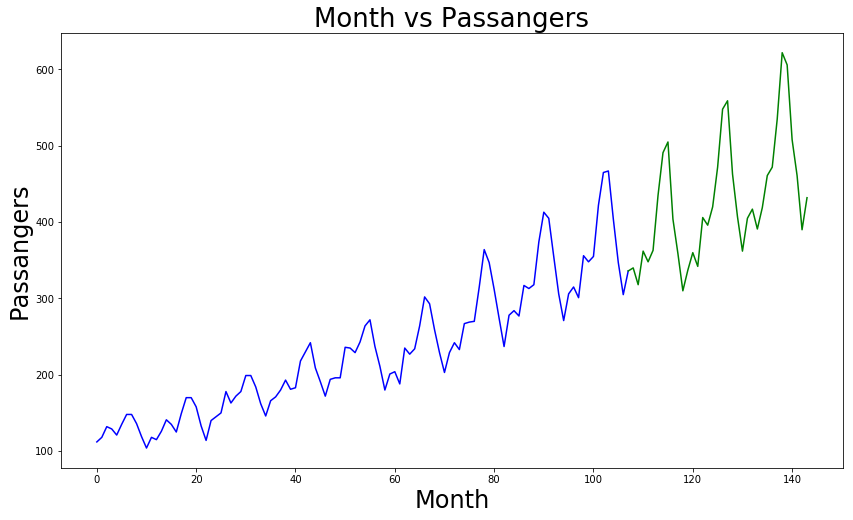

In [3]:
data = sp.loadtxt('datosT1P2.txt')

def read_data(data, PLOT=False):
    if PLOT:
        fig, ax = plt.subplots(figsize=(14,8))
        ax.plot(data[:, 0][:12*9], data[:, 1][:12*9], 'b')
        ax.plot(data[:, 0][12*9-1:], data[:, 1][12*9-1:], 'g')
        plt.title('Month vs Passangers', fontsize = 26)
        ax.set_xlabel('Month', fontsize=24)
        ax.set_ylabel('Passangers', fontsize=24)
        plt.show()
    return data[:, 0][:12*9], data[:, 1][:12*9], data[:, 0][12*9-1:], data[:, 1][12*9-1:]

t_months, t_pas, p_months, p_pas = read_data(data, PLOT=True)
all_months = sp.arange(144)

In [11]:
ndat = len(t_months)
th = sp.array([30.0, pi2/12, 4.9, 0.01])
th1 = sp.array([1.0, 1.0, 1.0, 0.01])

In [12]:
def solver(x, y, order, rho=0.01):
    def base(x, order):
        M = sp.ones(x.size)
        for i in sp.arange(order) + 1:
            M = sp.vstack([M, x ** i])
        return M.T
    phi = base(x, order)
    w = sp.linalg.solve(phi.T.dot(phi) + rho * sp.eye(order+1), phi.T).dot(y)
    x_out = sp.linspace(min(x), max(p_months), 1e3)
    y_out = base(x_out, order).dot(w)
    y_out += norm.pdf(y_out/sp.mean(y_out), 0, 1)
    res = sp.sum((base(t_months, order).dot(w) - t_pas) ** 2)
    y_mod = base(all_months, order).dot(w)
    y_mod += norm.pdf(y_mod/sp.mean(y_mod), 0, 1)
    #res = base(t_months, order).dot(w) - t_pas
    return sp.array([x_out, y_out, res, w, y_mod])

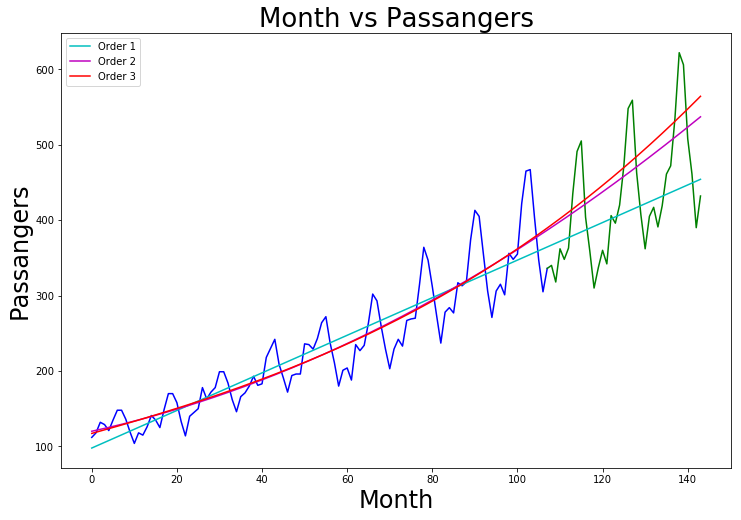

In [13]:
def compare(*sets):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(t_months, t_pas, 'b')
    ax.plot(p_months, p_pas, 'g')
    plt.title('Month vs Passangers', fontsize = 26)
    ax.set_xlabel('Month', fontsize=24)
    ax.set_ylabel('Passangers', fontsize=24)
    colores = sp.array(['c', 'm', 'r', 'y', 'k'])
    for i in range(len(sets)):
        ax.plot(sets[i][0], sets[i][1], colores[i], label='Order '+str(i+1))
    plt.legend()
    plt.show()

compare(solver(t_months, t_pas, 1), solver(t_months, t_pas, 2), solver(t_months, t_pas, 3))


In [14]:
def sinusoide(theta, x, polorder=3):
    A, B, C, D = theta
    w = solver(t_months, t_pas, 3)[3]
    pol = 0
    for i in range(polorder+1):
        pol += w[i] * x ** i
    sin = A * sp.sin(B * x + C) * sp.exp(D * x)
    #print A,B,C,D
    result = pol + sin
    result += norm.pdf(result/sp.mean(result), 0, 1)
    return result

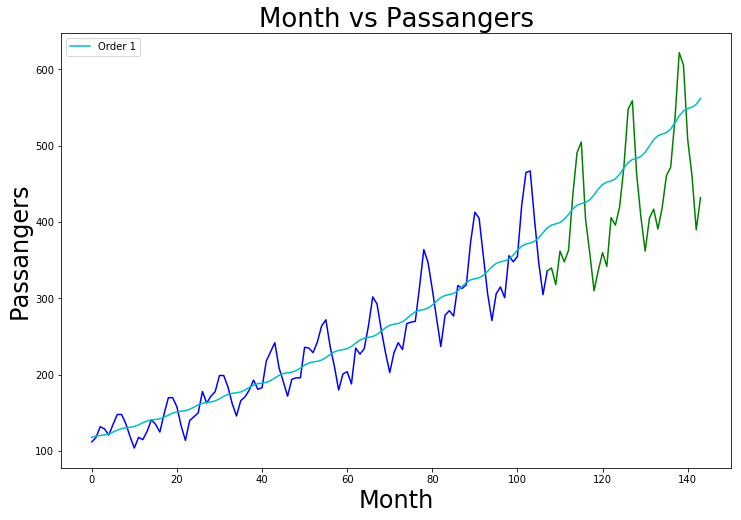

In [8]:
compare(sp.array([all_months, sinusoide(th1, all_months)]))

In [9]:
def lpsin(theta):
    logp = 0.
    A, B, C, D = theta
    #logp += sp.log(norm.pdf(A, 0, 1))
    logp += sp.log(norm.pdf(B, pi2/12, 0.1))
    logp += 0.
    #logp += sp.log(norm.pdf(D, 0.01, 0.001))
    return logp

def llsin(theta, x, y):
    sig2 = 0.1
    res = y - sinusoide(theta, x)
    lnl = sp.sum(res ** 2 / sig2 + sp.log(pi2 * sig2))
    #print(theta, res)
    return -0.5 * lnl

def lpostsin(theta, x, y):
    #logp = lpsin(theta)
    logl = llsin(theta, x, y)
    return logl# + logp

/home/reddtea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: overflow encountered in square
/home/reddtea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp
/home/reddtea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in multiply


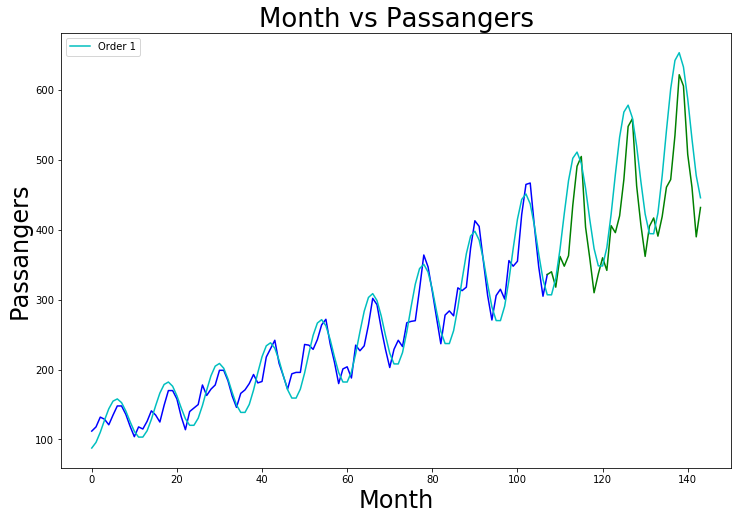

In [16]:
fit = BFGS(lpostsin, x0=th, args=(t_months, t_pas), approx_grad=True)[0]
#fit1 = BFGS(lpostsin, x0=th1, args=(t_months, t_pas), approx_grad=True)[0]
compare(sp.array([all_months, sinusoide(fit, all_months)]))

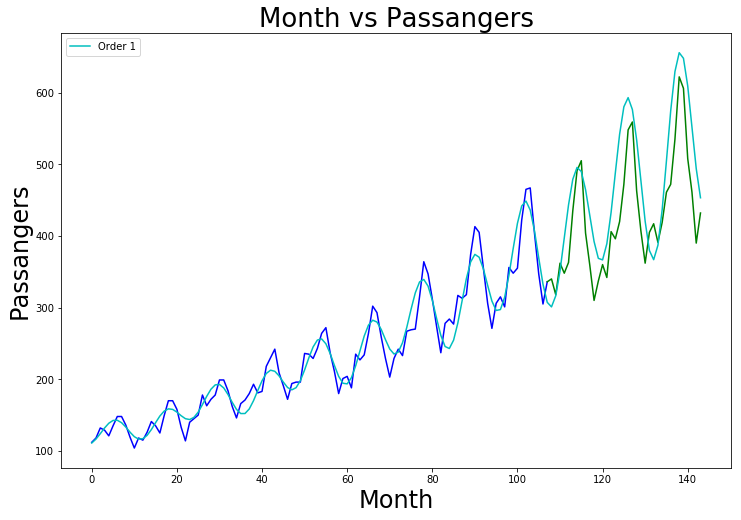

In [53]:
th2 = sp.array([6, pi2/24, 1, 0.01])
th0 = sp.zeros(4)
def REsinusoide(theta, x, polorder=3):
    A, B, C, D = theta
    A0, B0, C0, D0 = fit
    w = solver(t_months, t_pas, 3)[3]
    pol = 0
    for i in range(polorder+1):
        pol += w[i] * x ** i
    oldsin = A0 * sp.sin(B0 * x + C0) * sp.exp(D0 * x) 
    sin = A * sp.sin(B * x + C) * sp.exp(D * x)
    #print A,B,C,D
    result = pol + oldsin + sin
    # print result
    result += norm.pdf(result/sp.mean(result), 0, 1)
    return result

compare(sp.array([all_months, REsinusoide(th2, all_months)]))

In [ ]:
fit2 = BFGS(logpost, x0=th2, args=(t_months, t_pas), approx_grad=True)[0]
fit0 = BFGS(logpost, x0=th0, args=(t_months, t_pas), approx_grad=True)[0]
compare(sp.array([all_months, sinusoide(th, all_months)]))